Tif files are common for geoscience. We need a quick way to tile these and save them to our standard numpy tile dataset.

This notebook defines a function which:
1. converts a tif to a pytorch tensor
1. pads any nan areas with reflection padding 
1. unfolds the tensor in each direction (read torch .fold() / .unfold())
1. stacks those into a "batch" of tiles
1. generates a selection of indices for validation and training data
1. saves each to a seperate train/val folder
1. Generates some QA/QC figures

In [1]:
from pathlib import Path

import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import torch
import tifffile
from PIL import Image


def tifs_to_tensors(
    lr_raster_path,
    hr_raster_path,
    lr_out_prefix="lr_tiles",
    hr_out_prefix="hr_tiles",
    lr_s=32,  # lr tile res
    hr_s=128,  # hr tile res
    nan_val=-999999,
    ext="npy",
    norm=False,
):

    """
    Specify a LR and HR dataset pair. This will tile and save them to tensors
    ready to load in pytorch.
    """
    if norm:
        max_ = 213
        min_ = -315
        mean_ = -38
        std_ = 40

        # norm = lambda i: (i + 4403.574) / 18454.907 # values from training
        # unnorm = lambda i: (i * 18454.907) - 4403.574

        norm = lambda i: (i - min_) / (max_ - min_)  # values from training
        unnorm = lambda i: (i * (max_ - min_)) + min_
    else:
        norm = lambda i: i  # values from training
        unnorm = lambda i: i

    lr = tifffile.imread(lr_raster_path)
    hr = tifffile.imread(hr_raster_path)

    lr[lr == nan_val] = np.nan
    hr[hr == nan_val] = np.nan

    lr_tensor = torch.as_tensor(norm(lr), dtype=torch.float32).unsqueeze(0)
    hr_tensor = torch.as_tensor(norm(hr), dtype=torch.float32).unsqueeze(0)

    lr_original_extent = lr_tensor.shape
    hr_original_extent = hr_tensor.shape

    # Need full tiles.
    # padded_w = (lr_tensor.shape[0] + (lr_s - (lr_tensor.shape[0] % lr_s)))
    # padded_h = (lr_tensor.shape[1] + (lr_s - (lr_tensor.shape[1] % lr_s)))
    lr_tensor = torch.nn.functional.pad(
        lr_tensor,
        (
            0,
            (lr_s - (lr_tensor.shape[1] % lr_s)),
            0,
            (lr_s - (lr_tensor.shape[0] % lr_s)),
        ),
        mode="reflect",
    )
    hr_tensor = torch.nn.functional.pad(
        hr_tensor,
        (
            0,
            (hr_s - (hr_tensor.shape[1] % hr_s)),
            0,
            (hr_s - (hr_tensor.shape[0] % hr_s)),
        ),
        mode="reflect",
    )

    hr_tensor = hr_tensor[0]
    lr_tensor = lr_tensor[0]

    lr_tiles_per_row = lr_tensor.shape[1] // lr_s
    hr_tiles_per_row = hr_tensor.shape[1] // hr_s

    lr_tiles_per_column = lr_tensor.shape[0] // lr_s
    hr_tiles_per_column = hr_tensor.shape[0] // hr_s

    lr_patches = lr_tensor.unfold(0, lr_s, lr_s).unfold(1, lr_s, lr_s)
    hr_patches = hr_tensor.unfold(0, hr_s, hr_s).unfold(1, hr_s, hr_s)

    lr_patches = lr_patches.contiguous().view(
        lr_tiles_per_row * lr_tiles_per_column, -1, lr_s, lr_s
    )
    hr_patches = hr_patches.contiguous().view(
        hr_tiles_per_row * hr_tiles_per_column, -1, hr_s, hr_s
    )

    print(f"{len(lr_patches)=}")
    print(f"{len(hr_patches)=}")

    print(f"{lr_patches.shape=}")
    print(f"{hr_patches.shape=}")

    from numpy.random import default_rng

    rng = default_rng(seed=21)

    val_pc = 0.15
    val_num = int(np.round(val_pc * len(lr_patches)))  # len(lr_patches)
    val_indices = sorted(rng.choice(len(lr_patches), size=val_num, replace=False))
    print(f"{val_indices=}")

    train_indices = [i for i in range(len(lr_patches)) if i not in val_indices]
    print(f"{train_indices=}")

    print(
        f"There are {sum(i in train_indices for i in val_indices)} val indices in your train indices :)"
    )

    lr_patches_train = lr_patches[train_indices].numpy().astype(np.float32) #TODO shift if save as .pt
    hr_patches_train = hr_patches[train_indices].numpy().astype(np.float32)
    lr_patches_val = lr_patches[val_indices].numpy().astype(np.float32)
    hr_patches_val = hr_patches[val_indices].numpy().astype(np.float32)

    print(f"{len(lr_patches_train)=}")
    print(f"{len(lr_patches_val)=}")

    print(f"{np.nanmin(lr_patches_train)=}")
    print(f"{np.nanmax(lr_patches_train)=}")
    print(f"{np.nanmean(lr_patches_train)=}")
    print(f"{np.nanstd(lr_patches_train)=}")
    # print(f"{np.nanmin(hr_patches_train)=}")
    # print(f"{np.nanmax(hr_patches_train)=}")

    train_dir = Path(hr_raster_path).parent / ext / "train"
    val_dir = Path(hr_raster_path).parent / ext / "val"
    train_dir.mkdir(parents=True, exist_ok=True)
    val_dir.mkdir(parents=True, exist_ok=True)

    if "npy" in ext:
        np.save(
            train_dir / f"{Path(lr_raster_path).stem}_lr_4-0.{ext}",
            lr_patches_train,
        )
        np.save(
            train_dir / f"{Path(hr_raster_path).stem}_hr_1-0.{ext}",
            hr_patches_train,
        )
        np.save(
            val_dir / f"{Path(lr_raster_path).stem}_lr_4-0.{ext}",
            lr_patches_val,
        )
        np.save(
            val_dir / f"{Path(hr_raster_path).stem}_hr_1-0.{ext}",
            hr_patches_val,
        )


    if "tif" in ext:
        (train_dir / "hr").mkdir(exist_ok=True, parents=True)
        (train_dir / "lr").mkdir(exist_ok=True, parents=True)
        (val_dir / "hr").mkdir(exist_ok=True, parents=True)
        (val_dir / "lr").mkdir(exist_ok=True, parents=True)

        for i in range(len(lr_patches_train)):
            tifffile.imsave(
                train_dir / "lr" / f"{i}.{ext}", #_{Path(lr_raster_path).stem}_lr_4-0
                lr_patches_train[i],
            )
            tifffile.imsave(
                train_dir / "hr" / f"{i}.{ext}", #_{Path(hr_raster_path).stem}_hr_1-0
                hr_patches_train[i],
            )

        for i in range(len(lr_patches_val)):
            tifffile.imsave(
                val_dir / "lr" / f"{i}.{ext}", #_{Path(lr_raster_path).stem}_lr_4-0
                lr_patches_val[i],
            )
            tifffile.imsave(
                val_dir / "hr" / f"{i}.{ext}", #_{Path(hr_raster_path).stem}_hr_1-0
                hr_patches_val[i],
            )

    print(f"\nSaved to {val_dir.parent}")
    print(val_dir / f"{Path(lr_raster_path).stem}_lr_4-0.{ext}")
    print(val_dir / f"{Path(hr_raster_path).stem}_hr_1-0.{ext}")
    
    return lr_patches, hr_patches, val_indices


In [2]:
def check_tiles(lr_path, hr_path, index=0, ext="np", s=256):
    if "np" in ext:
        lr_tile = np.load(lr_path)[index][0]
        hr_tile = np.load(hr_path)[index][0]
    elif "tif" in ext:
        lr_tile = tifffile.imread(f"{lr_path}").squeeze()
        hr_tile = tifffile.imread(f"{hr_path}").squeeze()

    us = np.array(Image.fromarray(lr_tile).resize((s, s)))

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(us, vmin=hr_tile.min(), vmax=hr_tile.max())
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.imshow(hr_tile)
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.imshow(hr_tile - us, cmap=cc.cm.CET_D7, vmin=-0.5, vmax=0.5)
    plt.colorbar()


In [3]:
root = "D:/luke/SRvey/data_train/P738"
lr_patches, hr_patches, val_indices = tifs_to_tensors(
    f"{root}/P738_x4_250_clip.tif",
    f"{root}/P738_x1_62-5_clip.tif",
    ext="tif",
    norm=True,
)


len(lr_patches)=308
len(hr_patches)=308
lr_patches.shape=torch.Size([308, 1, 32, 32])
hr_patches.shape=torch.Size([308, 1, 128, 128])
val_indices=[18, 24, 31, 55, 56, 60, 65, 66, 77, 79, 92, 102, 109, 116, 117, 124, 134, 135, 138, 145, 161, 169, 171, 190, 192, 195, 200, 205, 206, 215, 230, 234, 244, 249, 252, 257, 262, 268, 270, 279, 281, 285, 286, 290, 301, 302]
train_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164

C:\Users\22905007\AppData\Local\Temp/ipykernel_21240/2127904256.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 10))


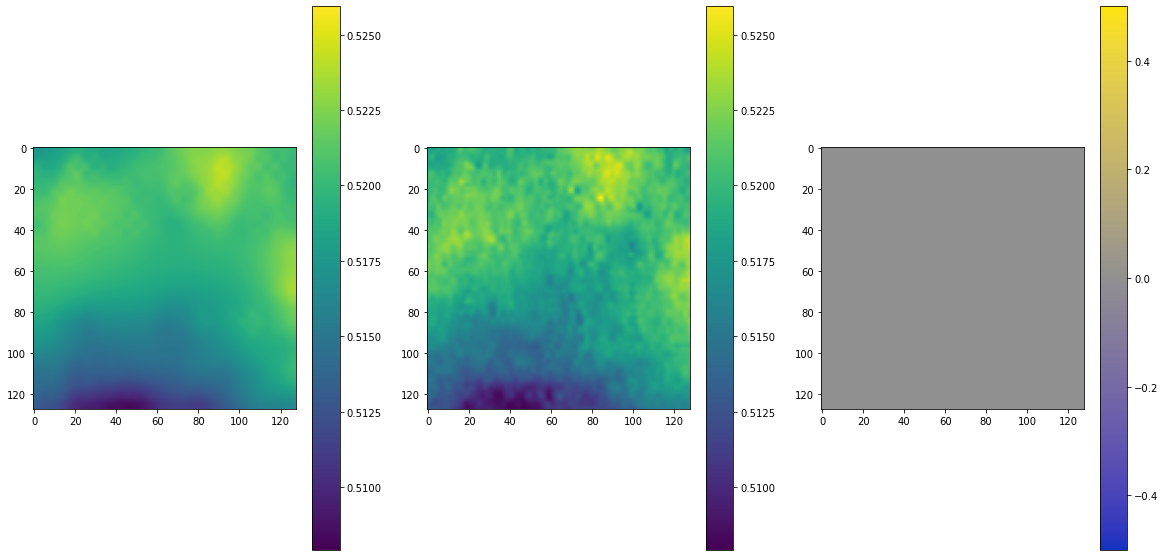

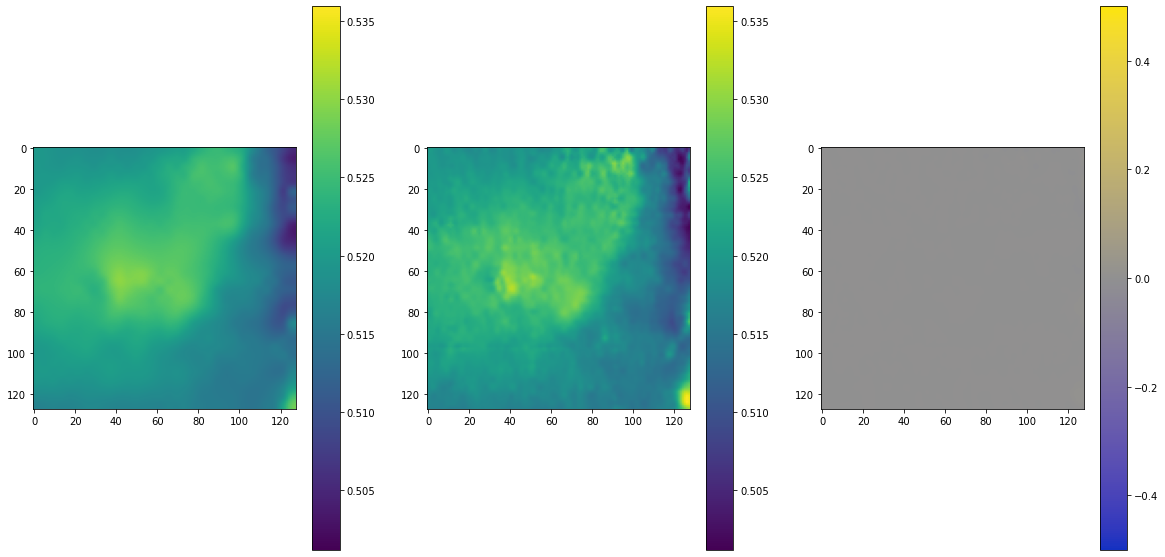

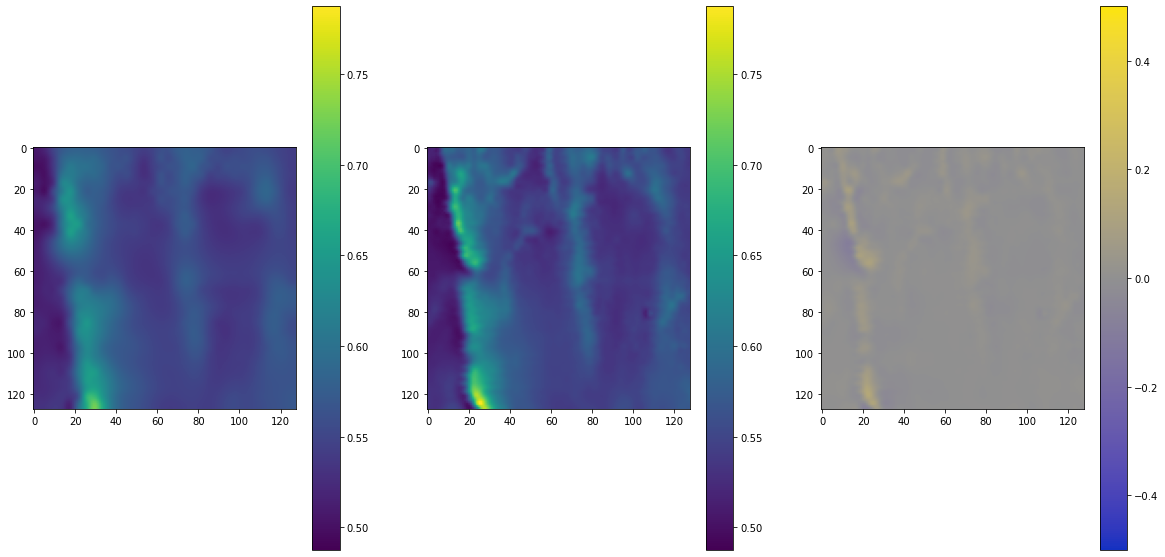

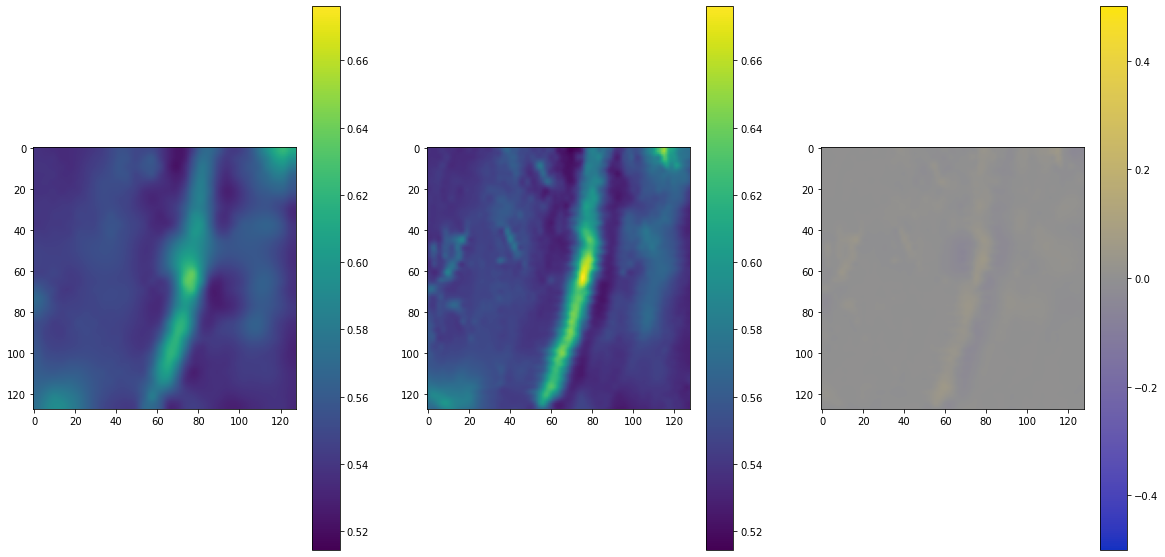

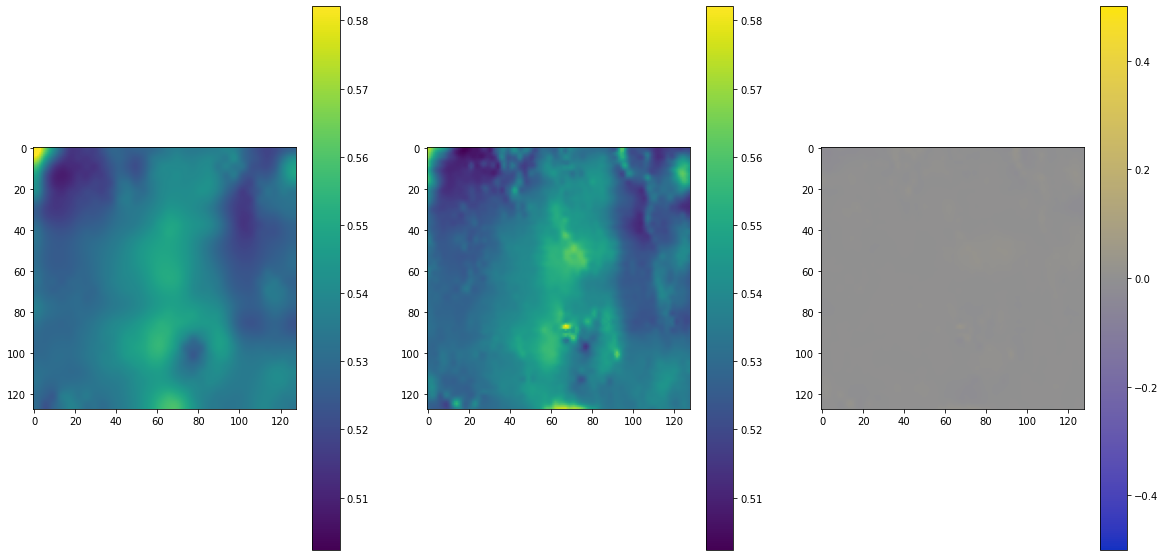

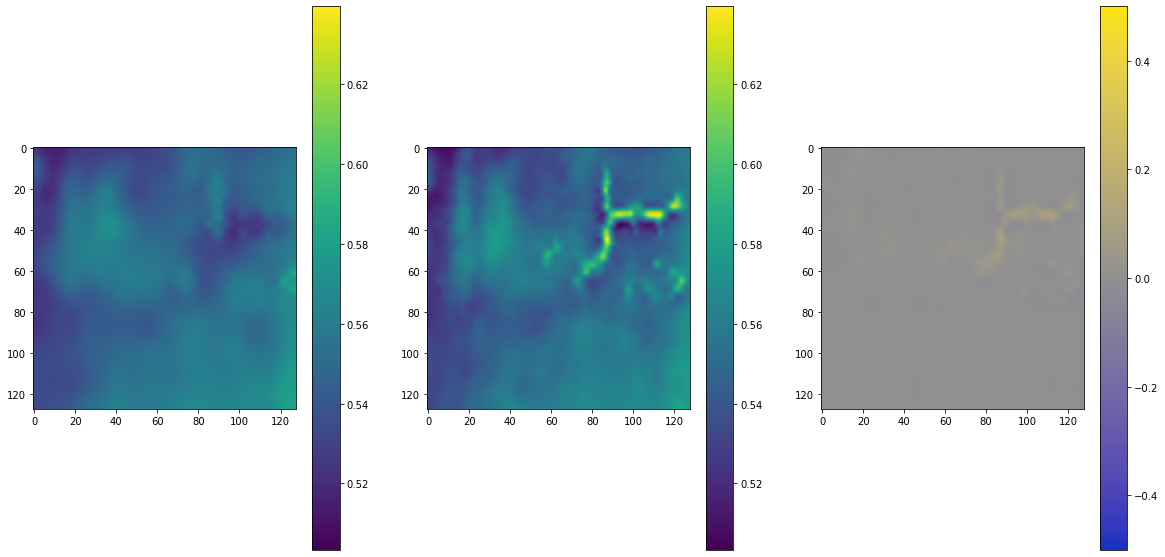

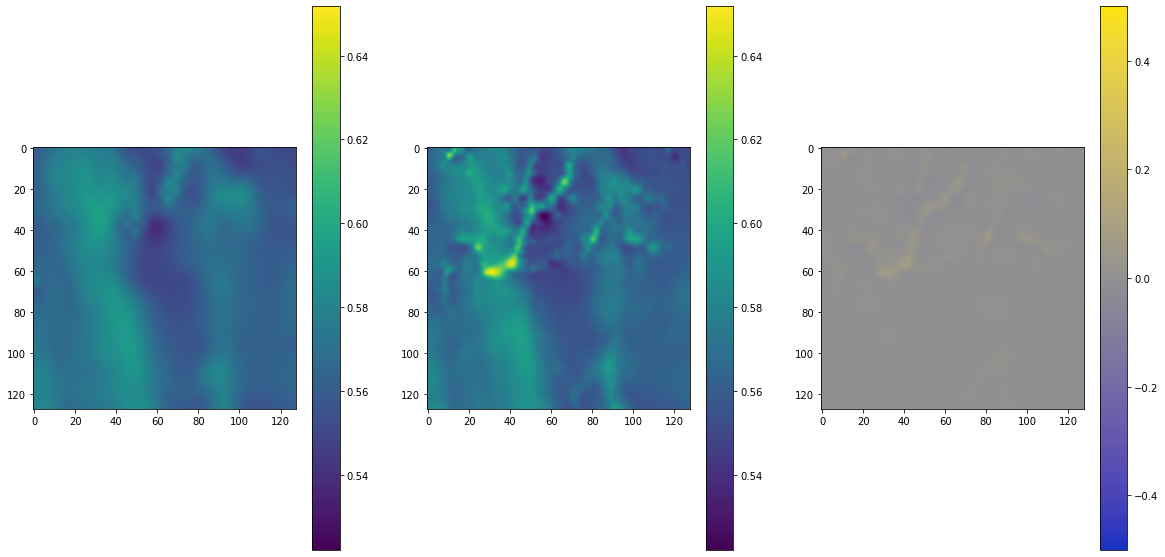

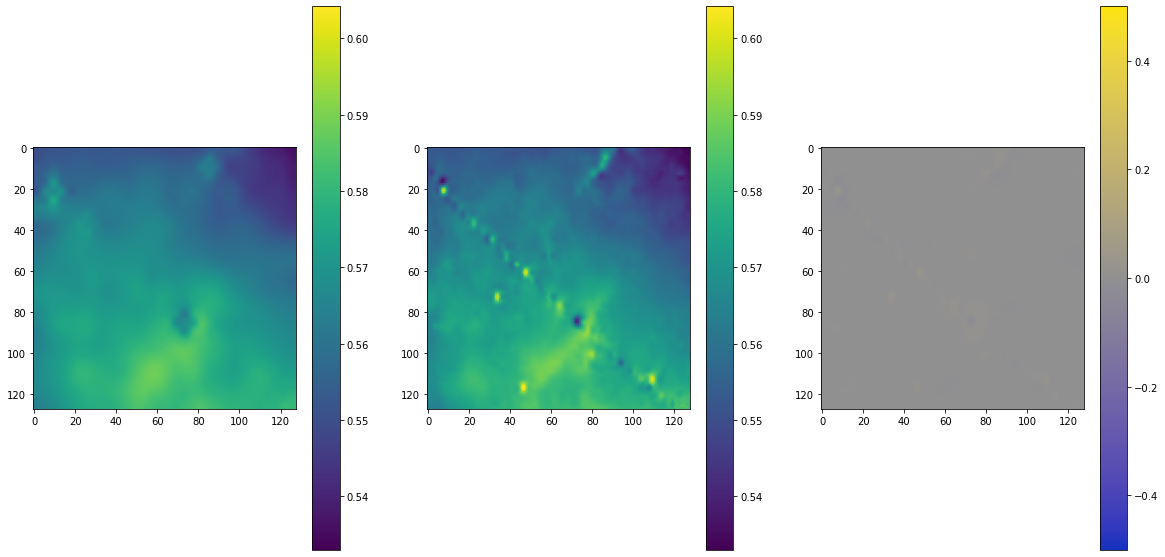

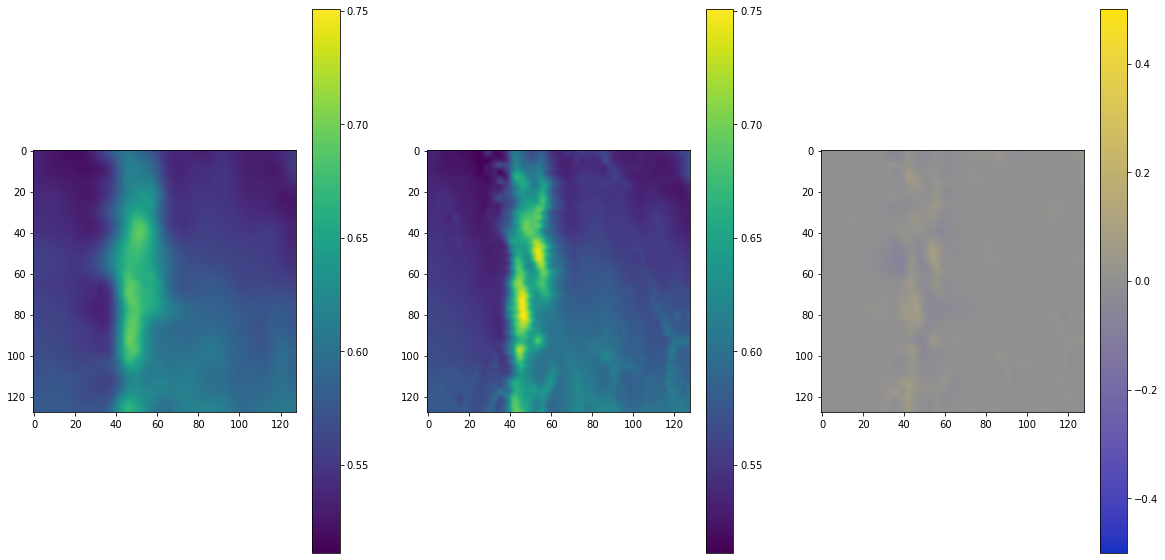

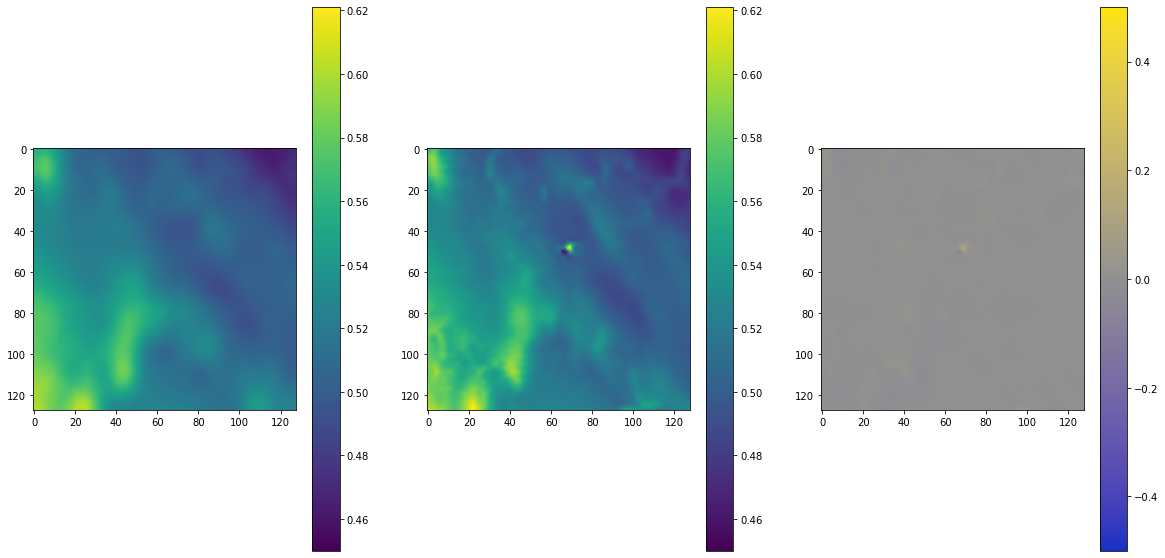

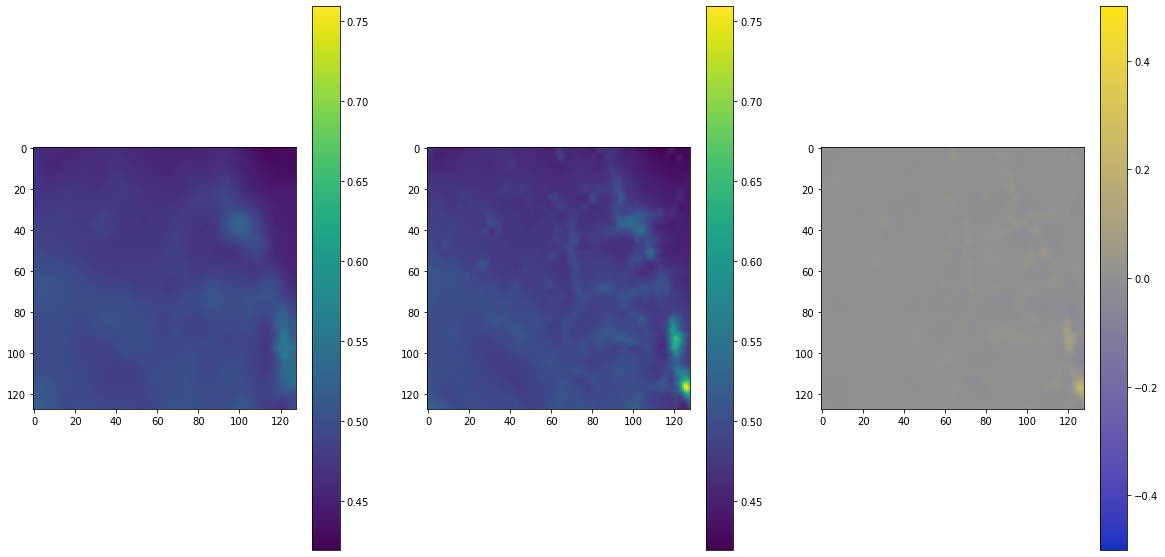

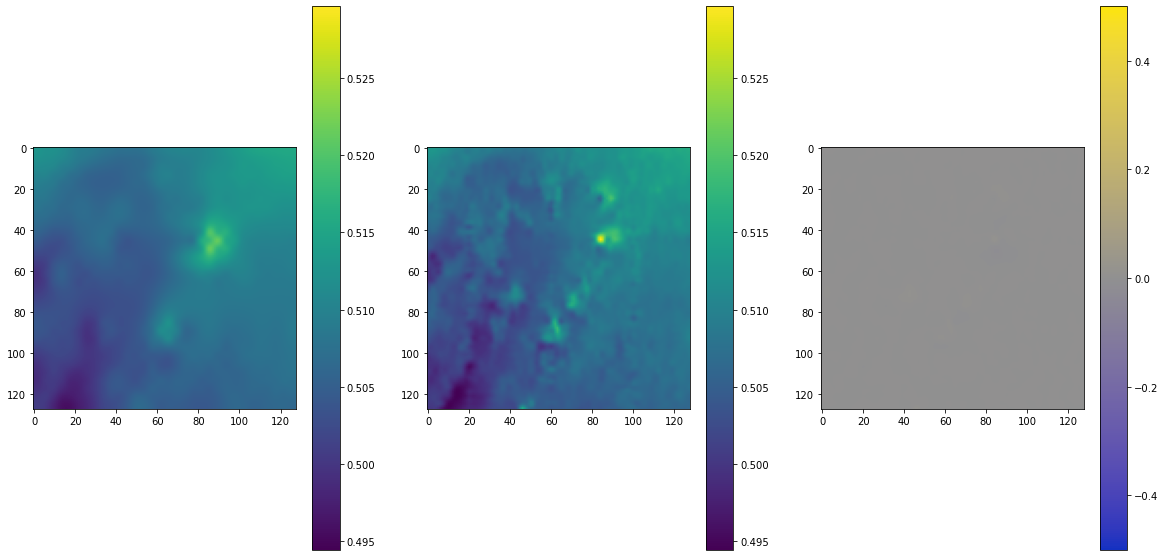

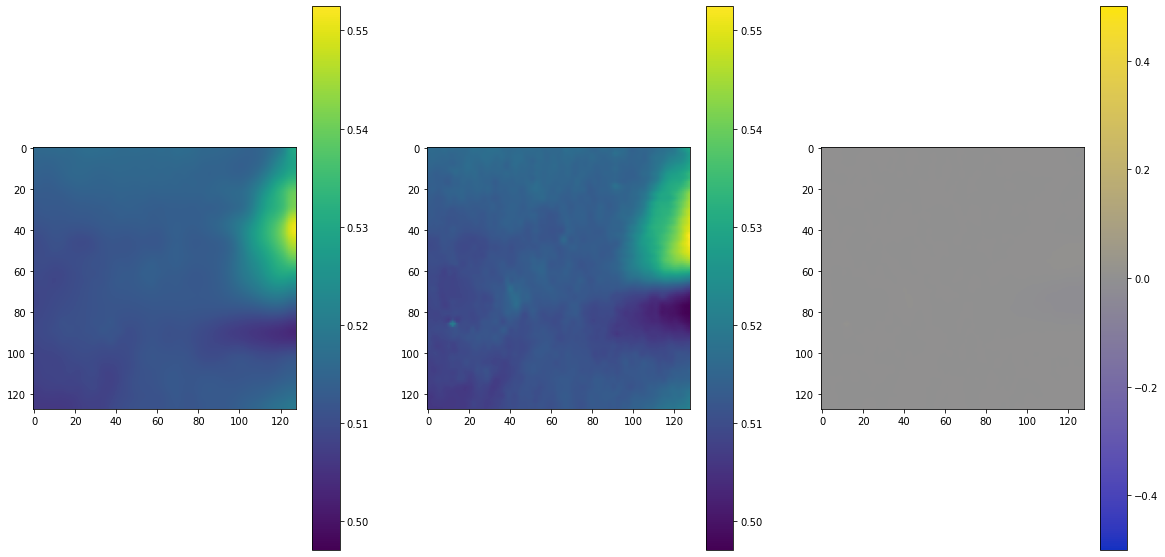

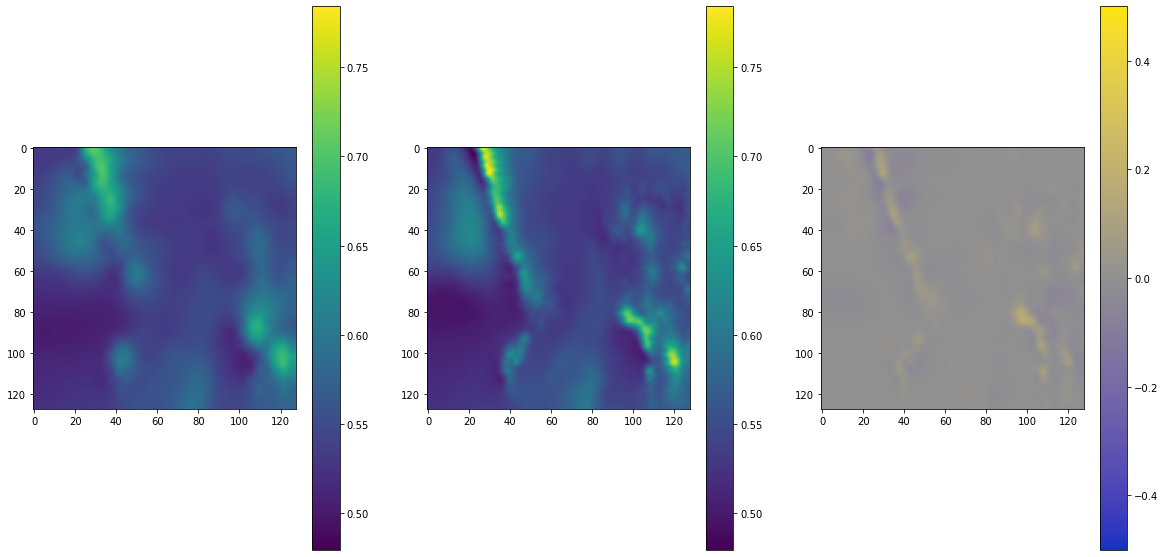

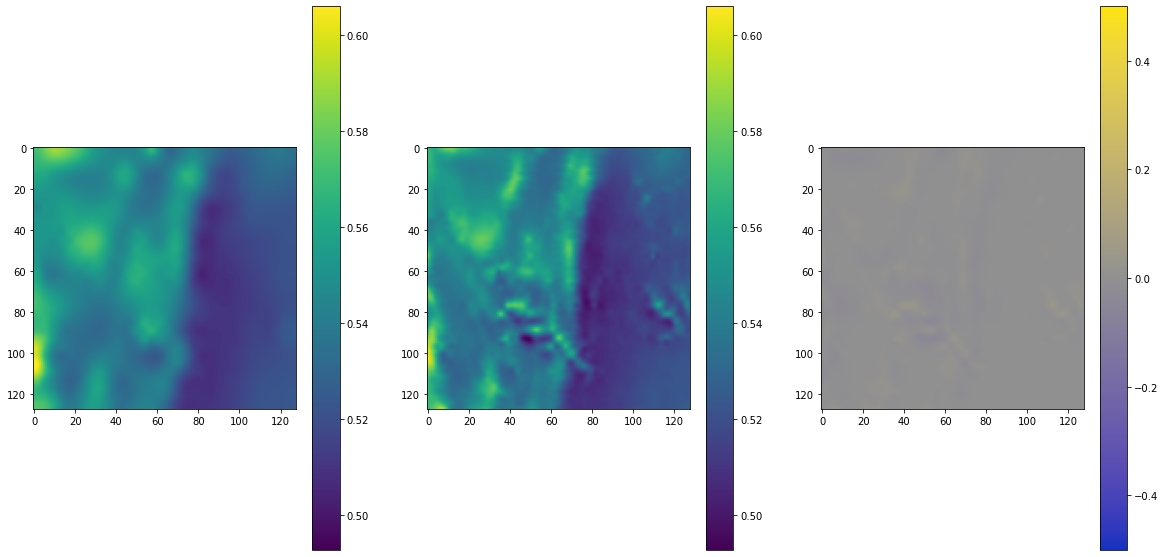

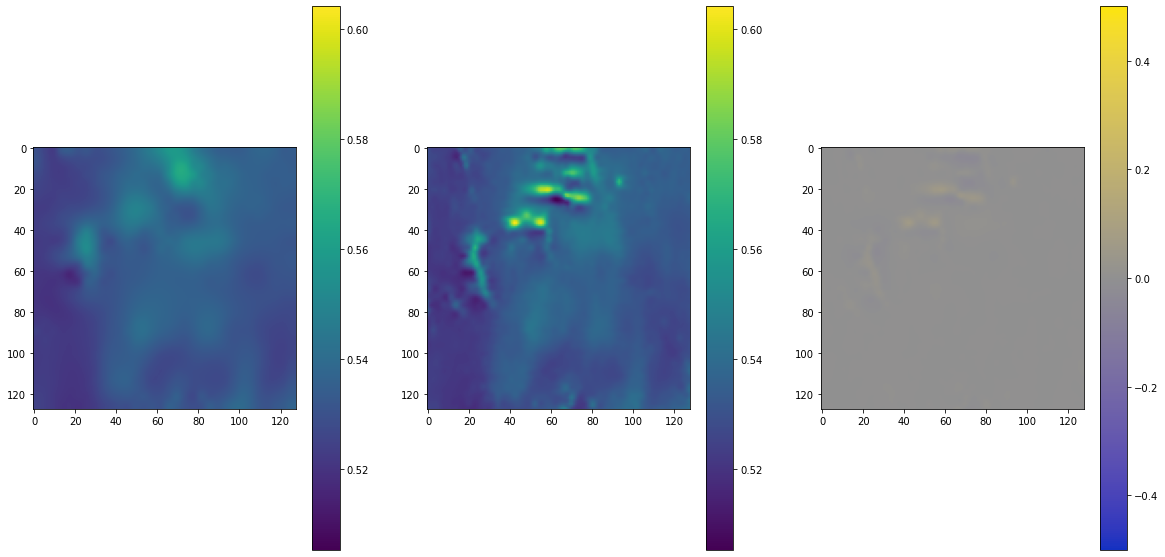

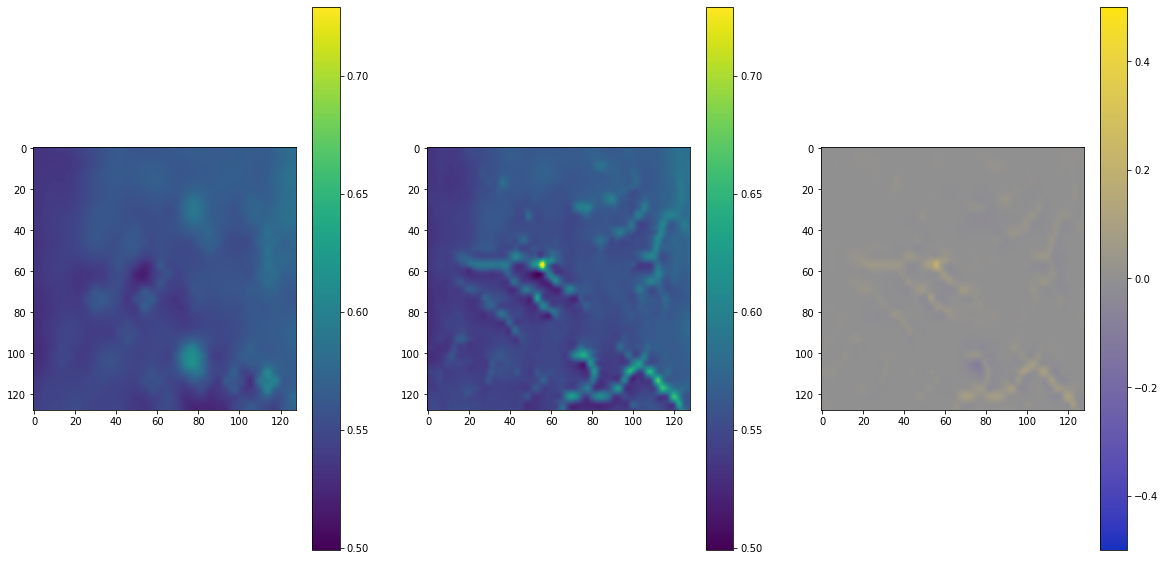

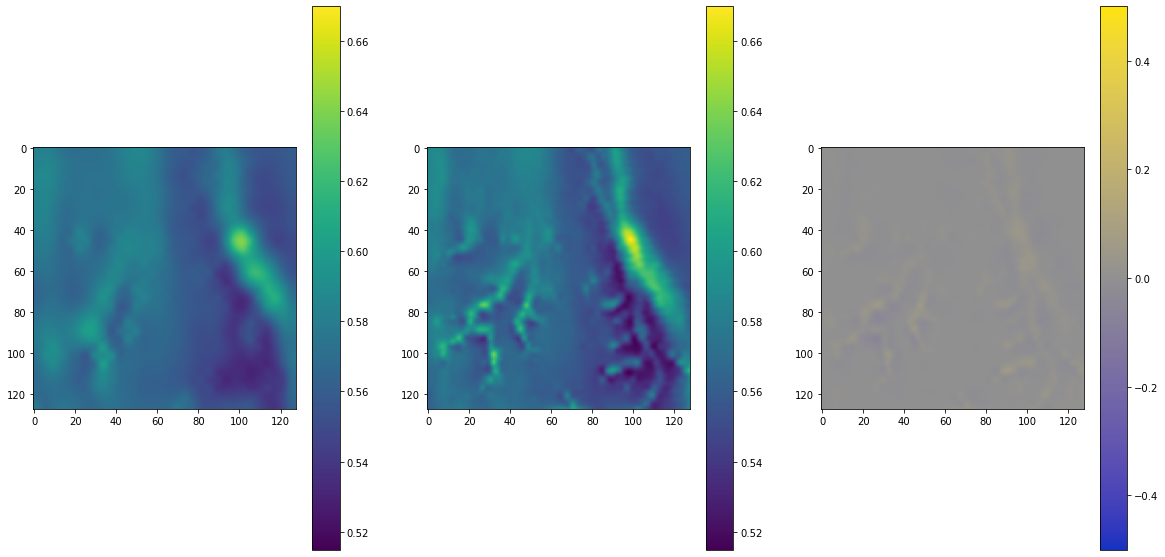

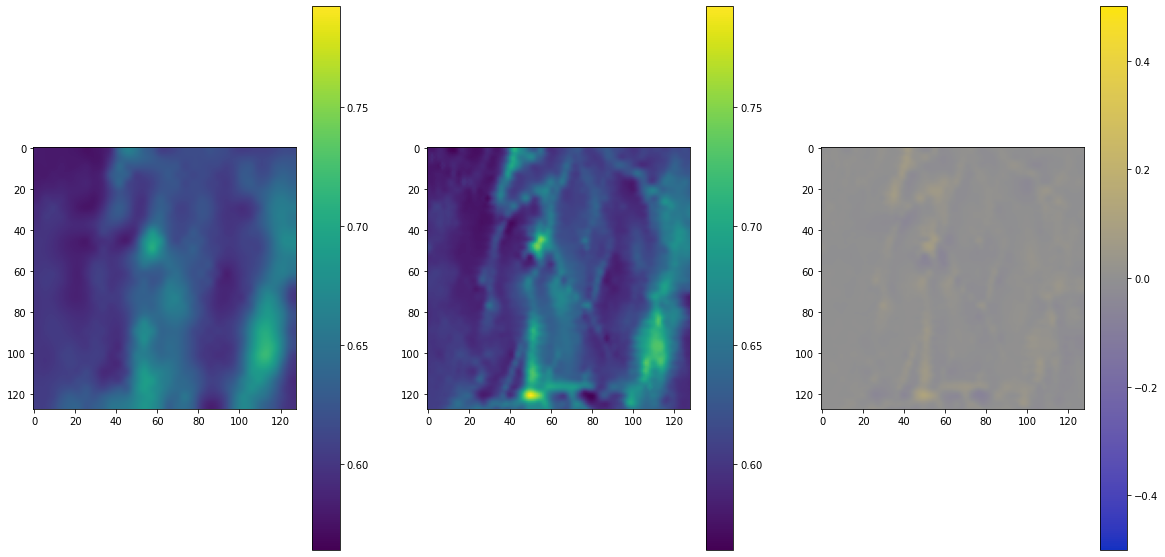

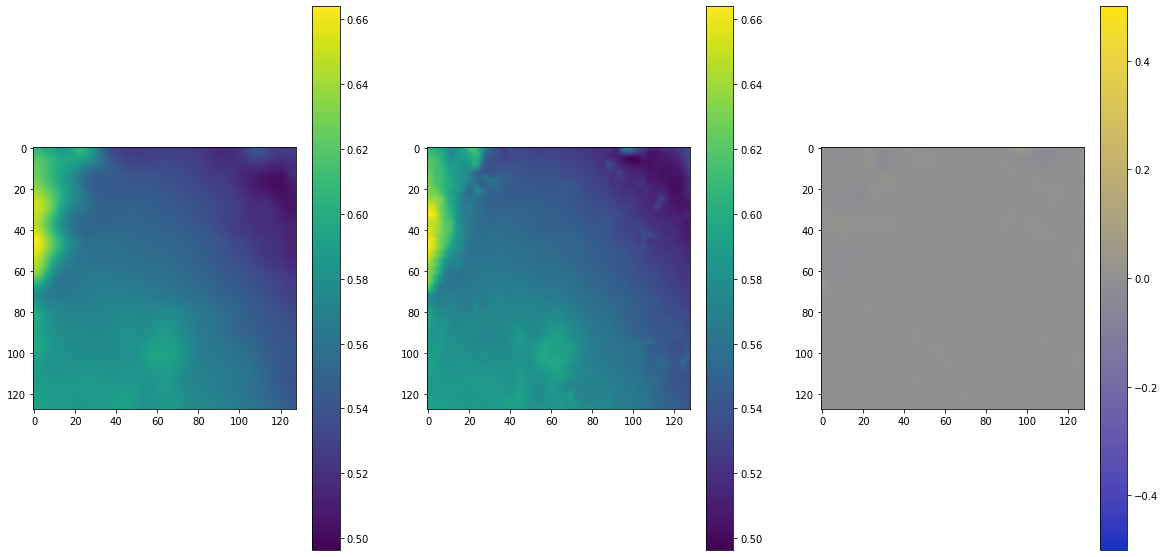

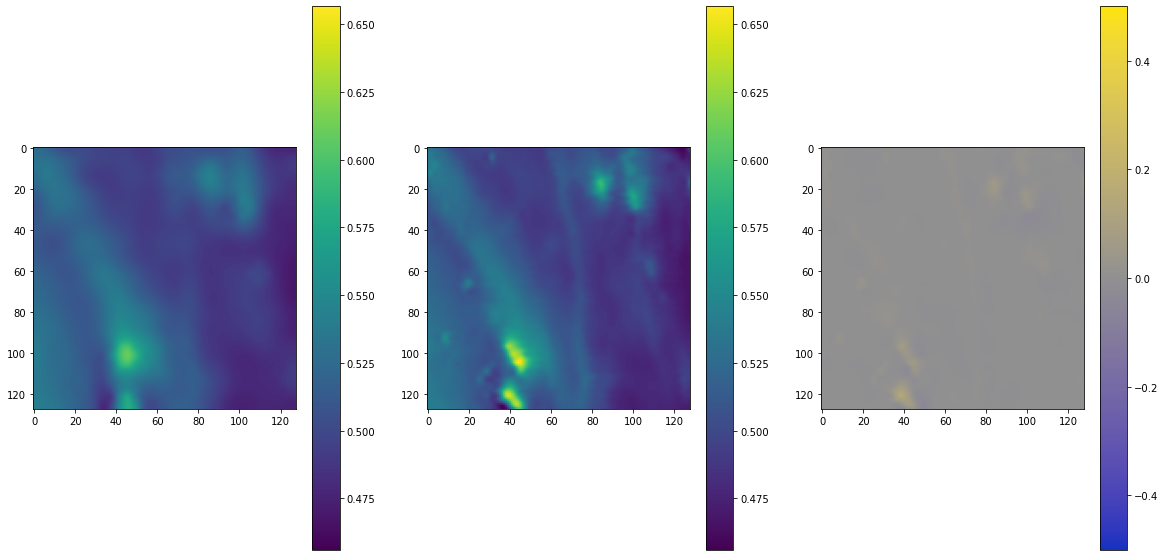

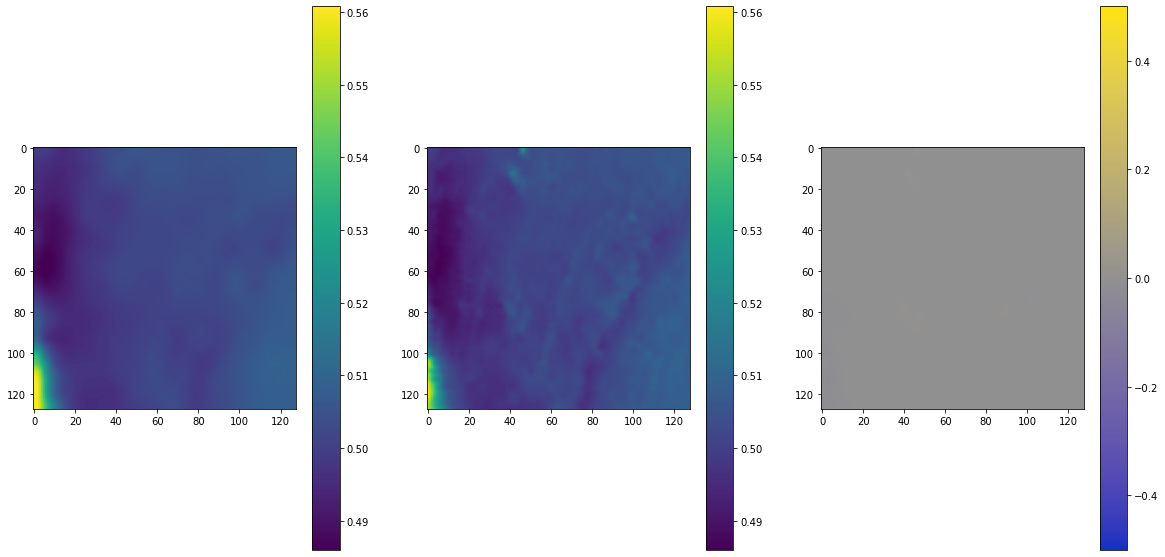

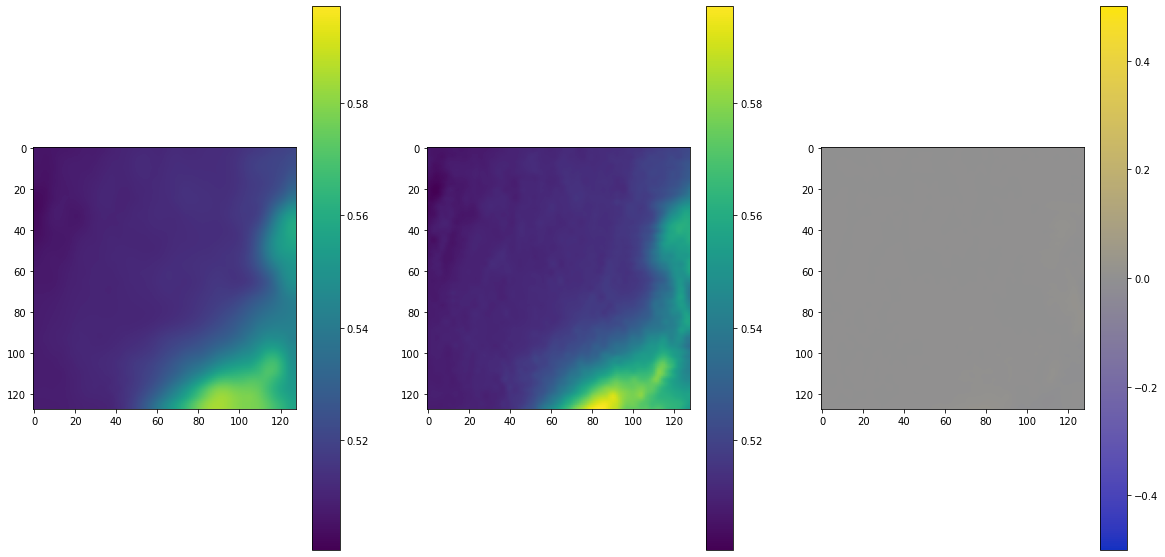

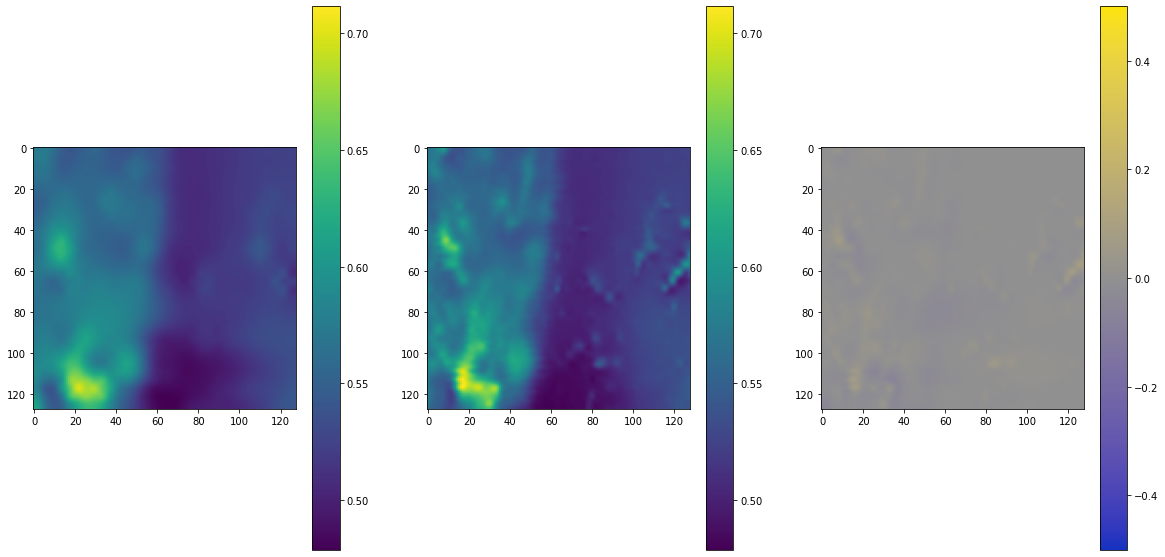

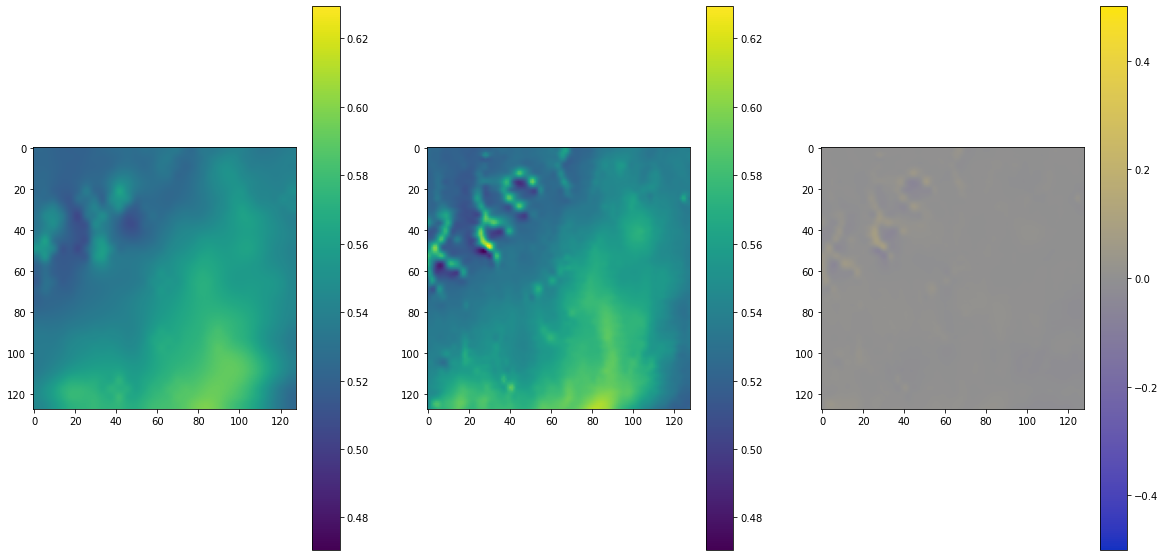

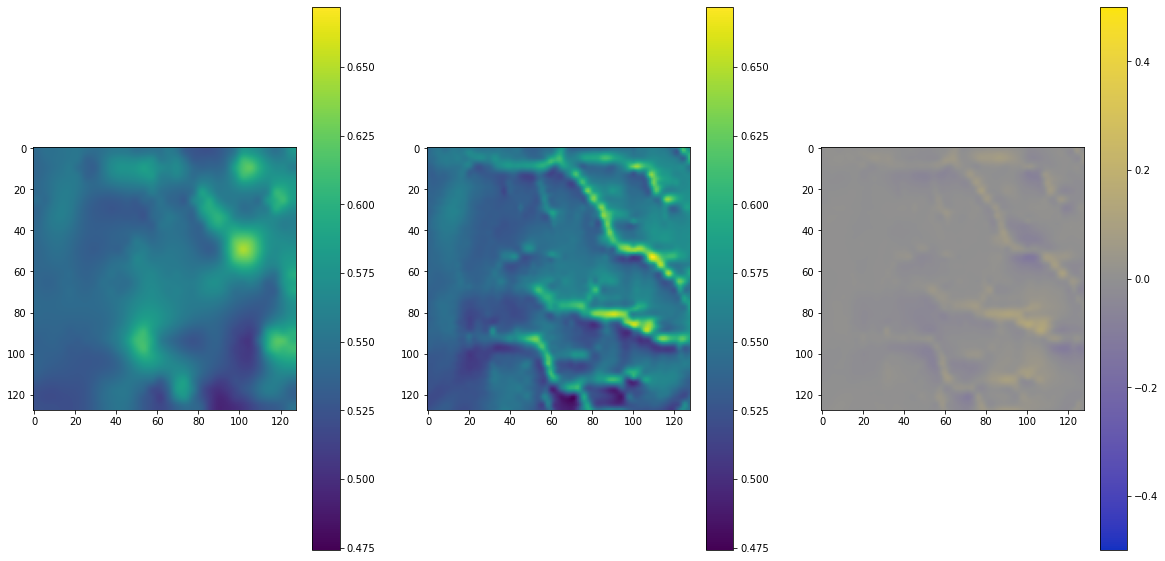

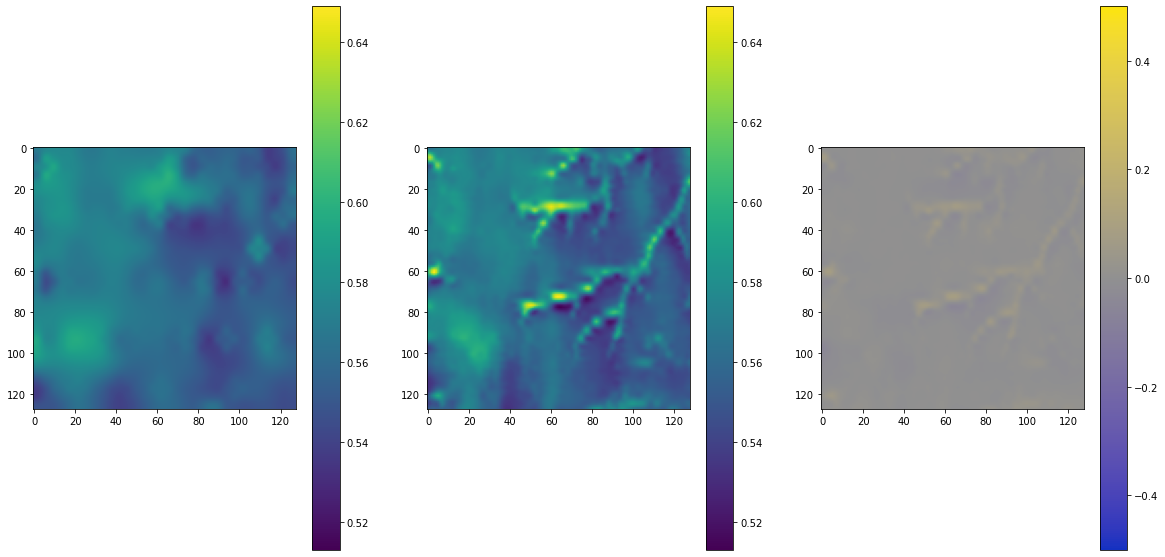

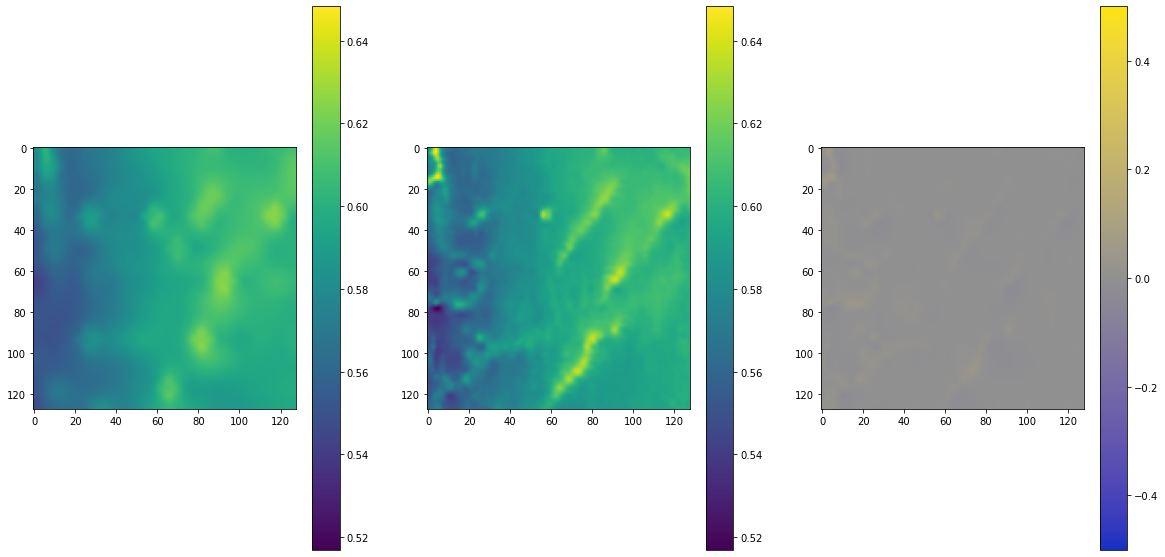

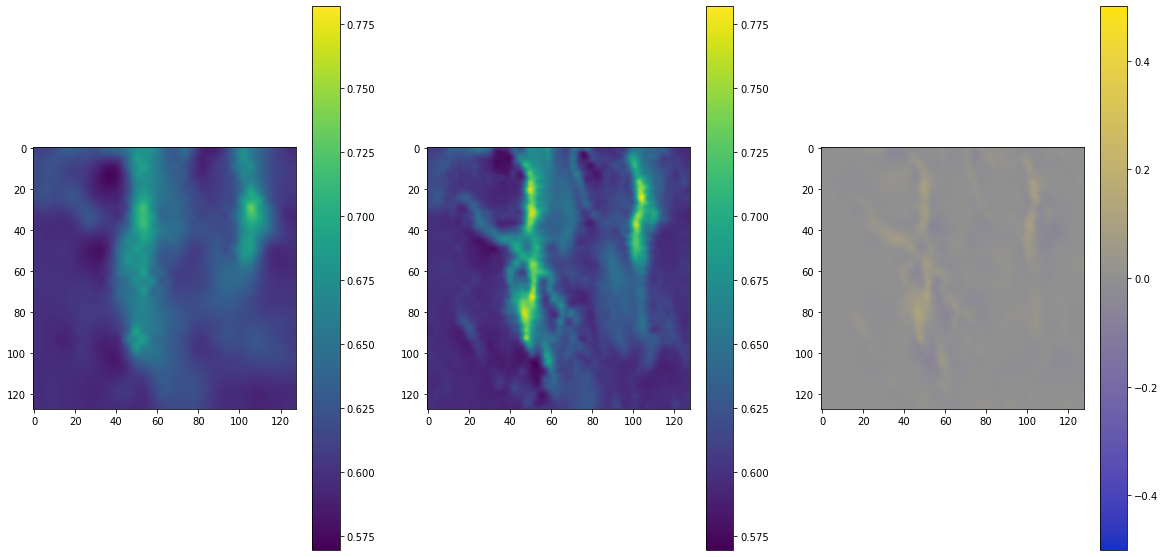

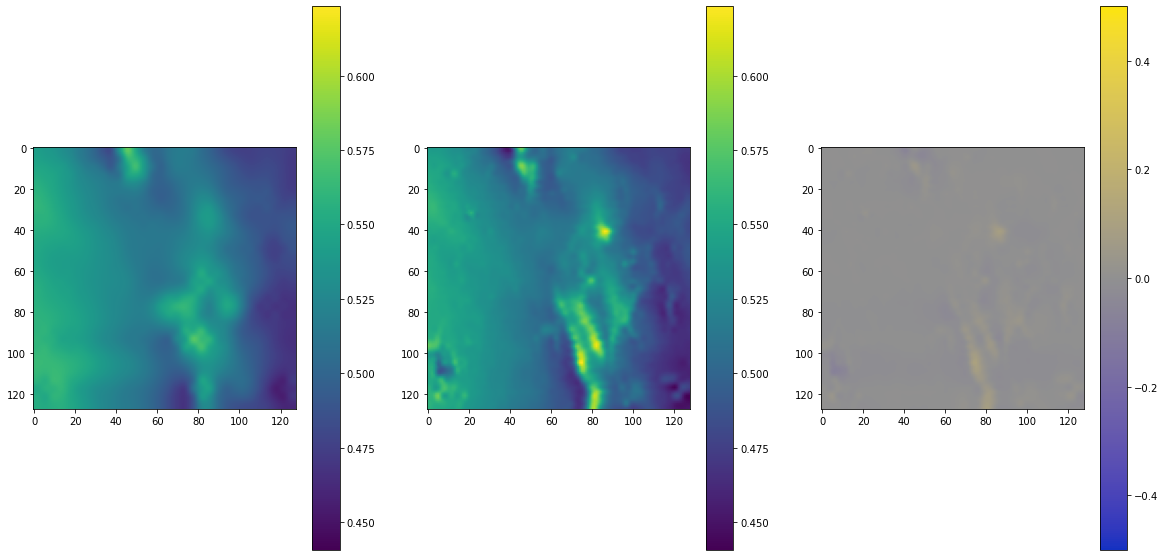

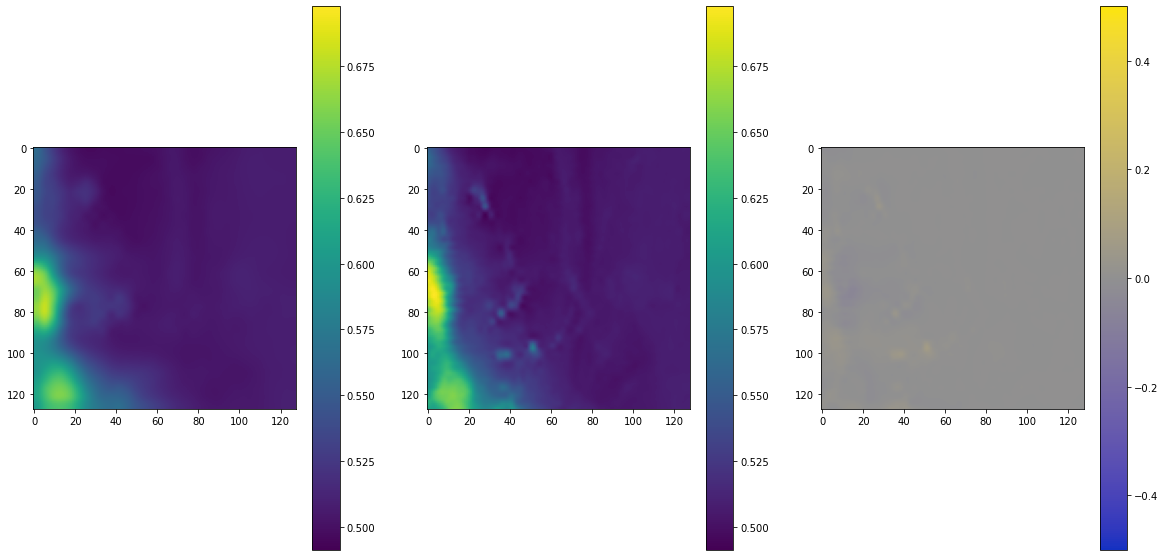

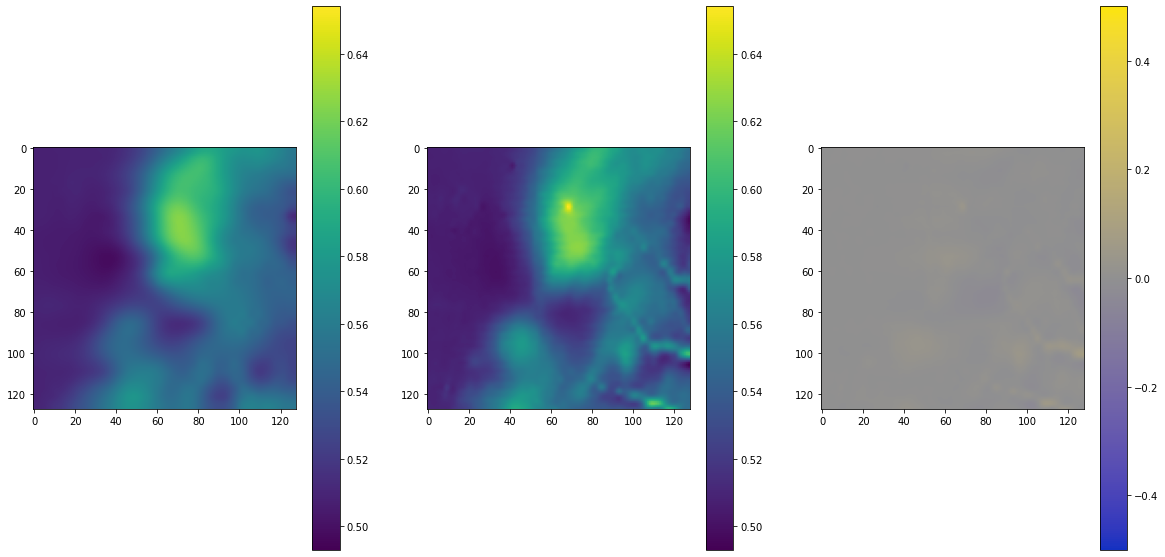

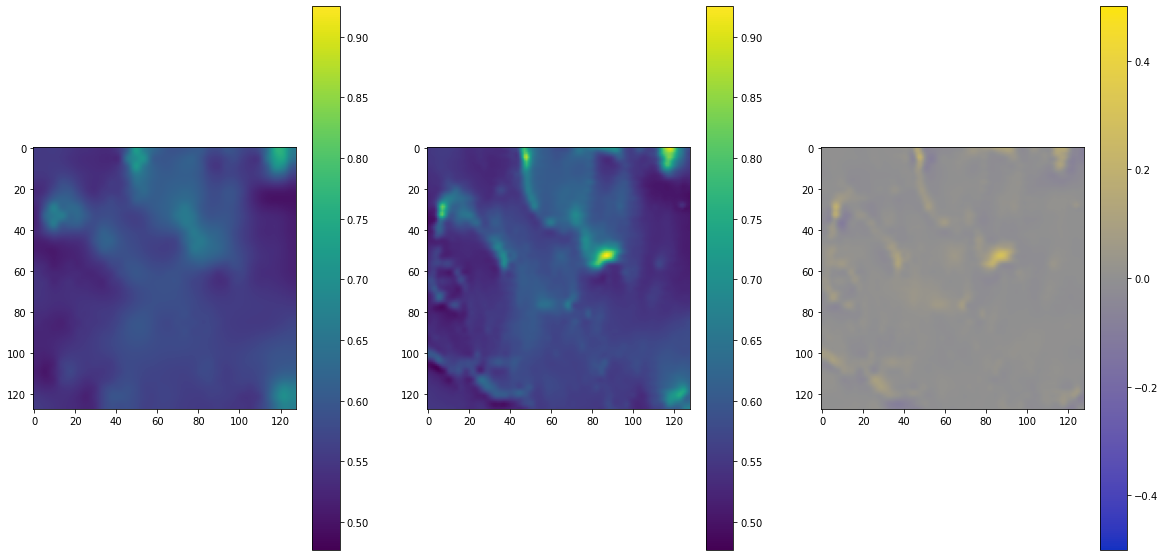

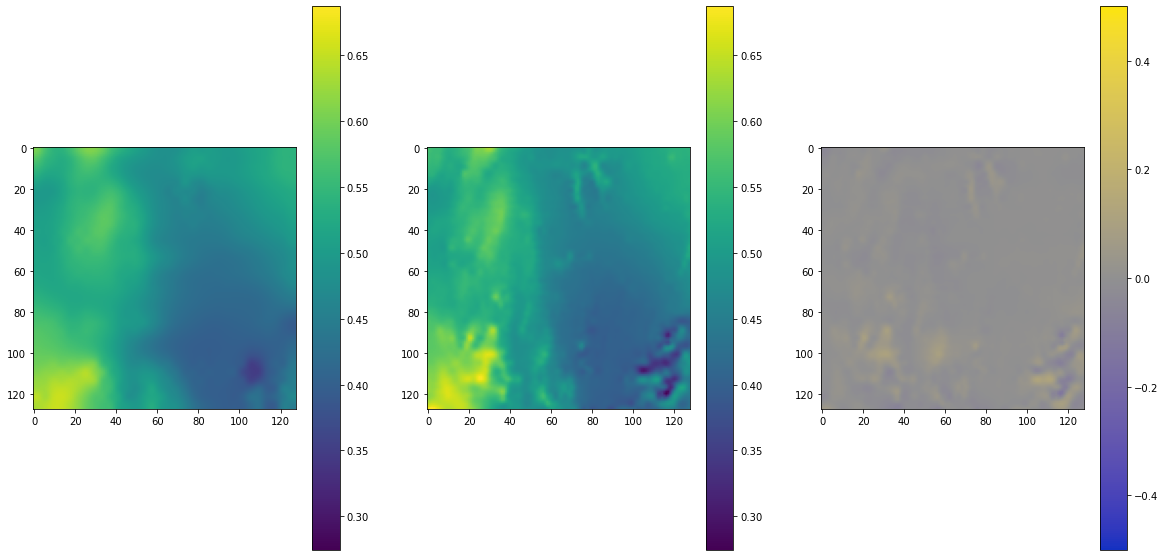

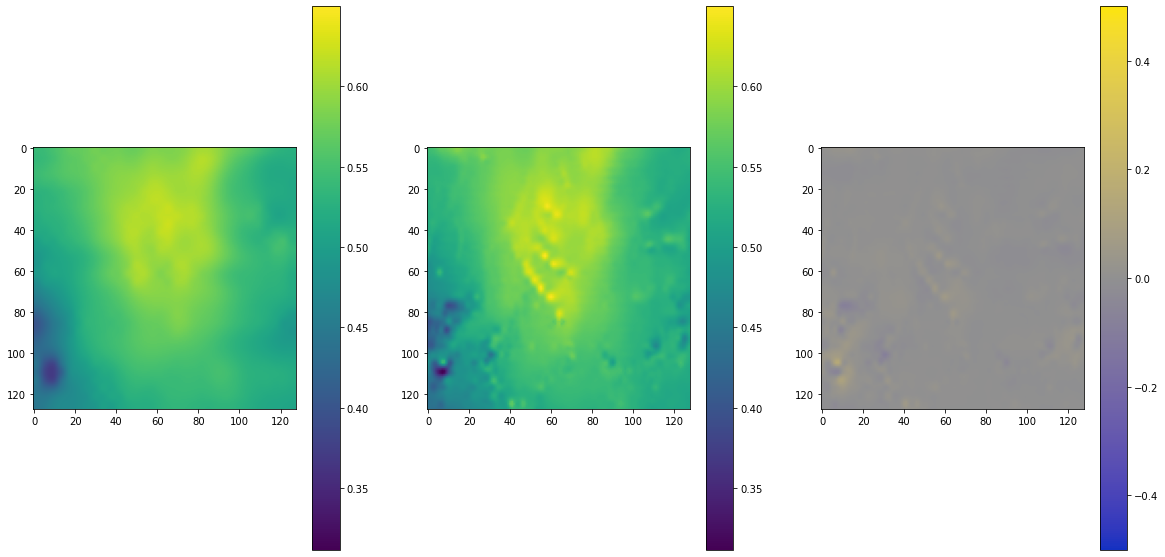

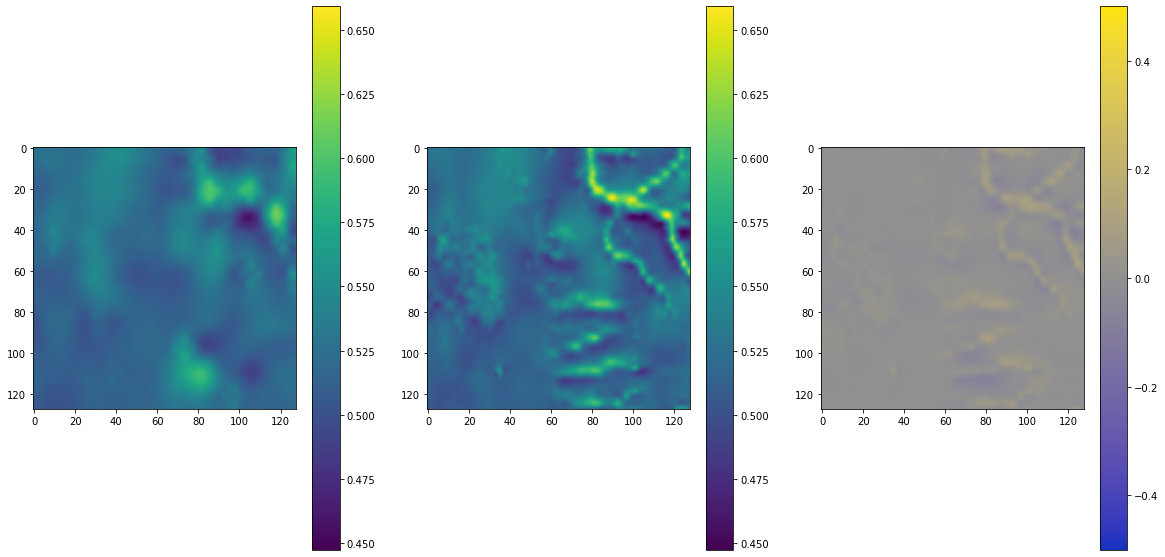

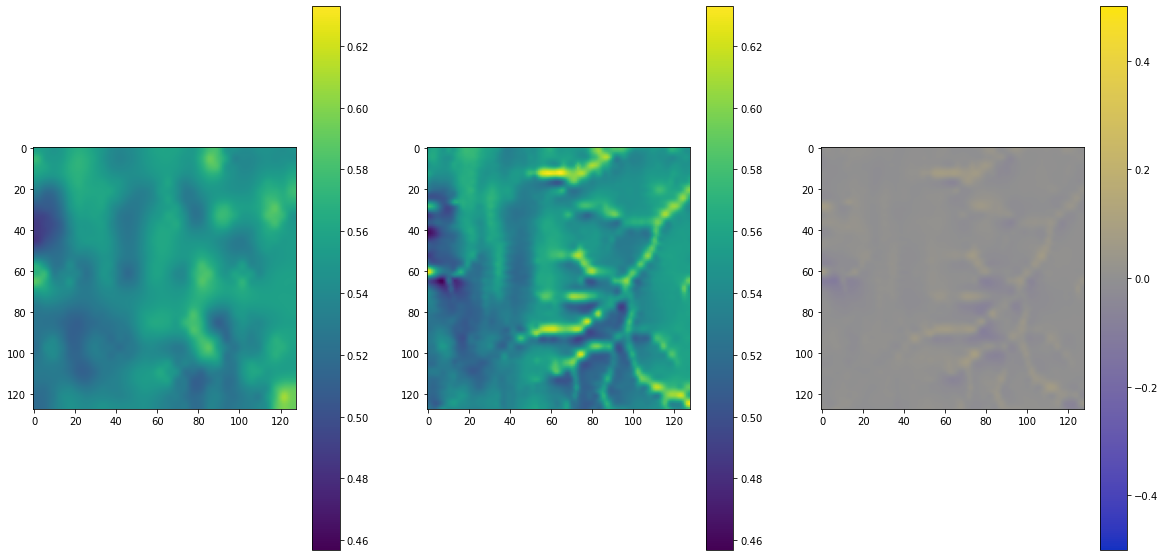

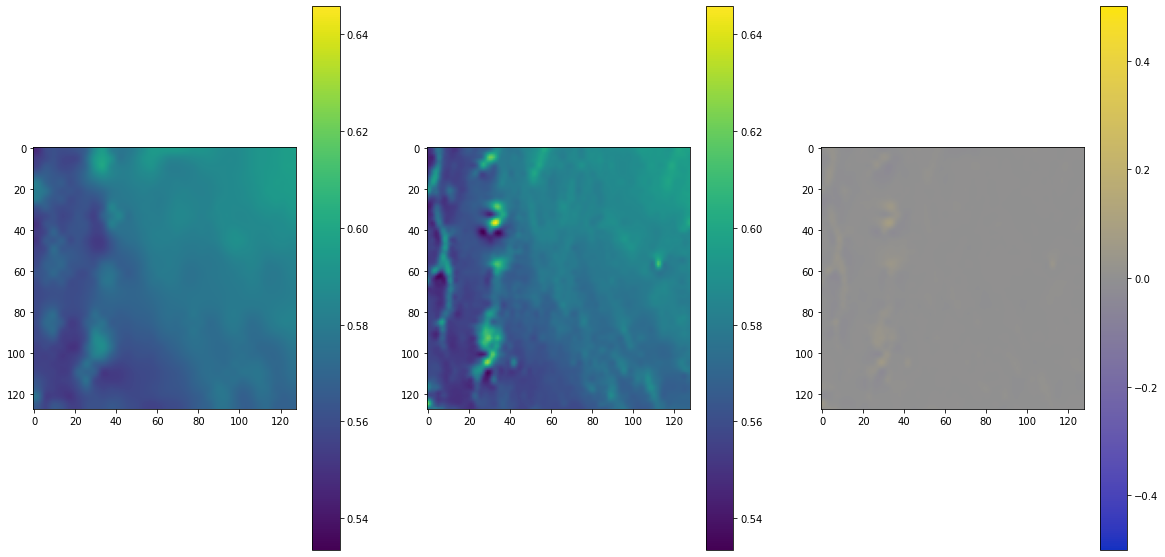

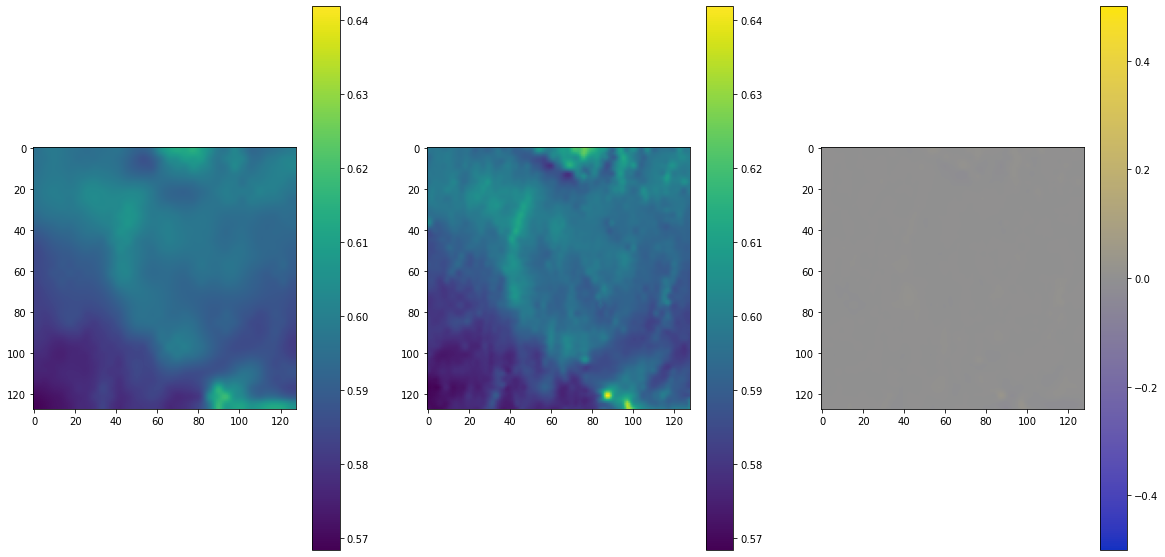

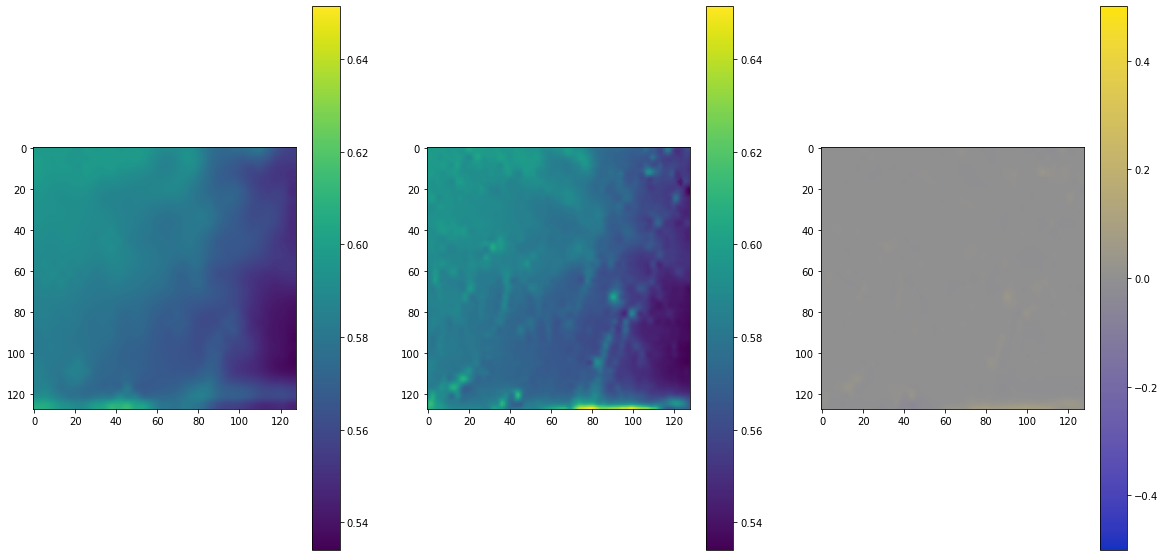

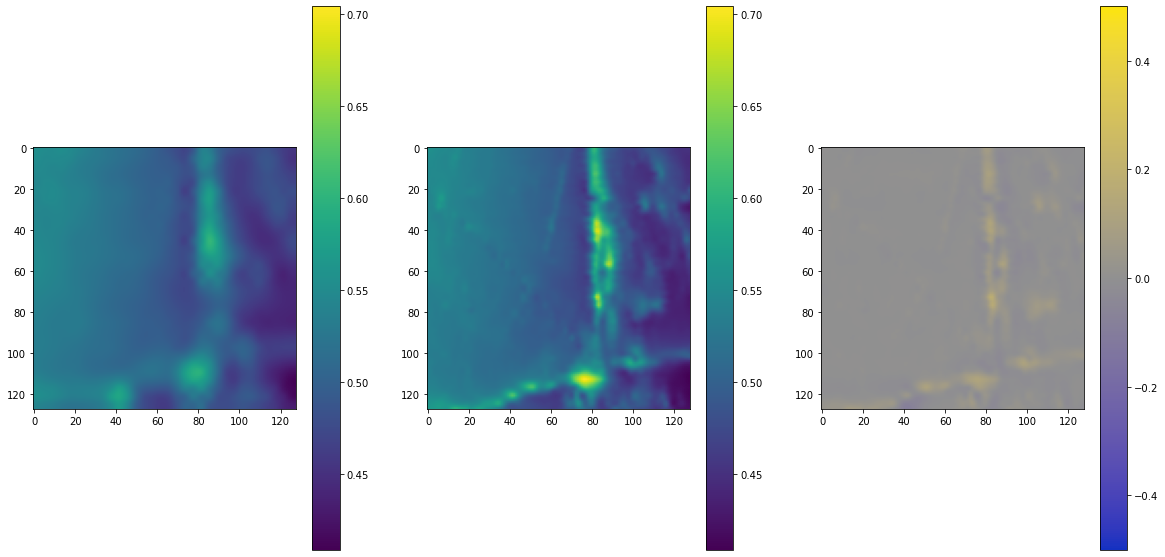

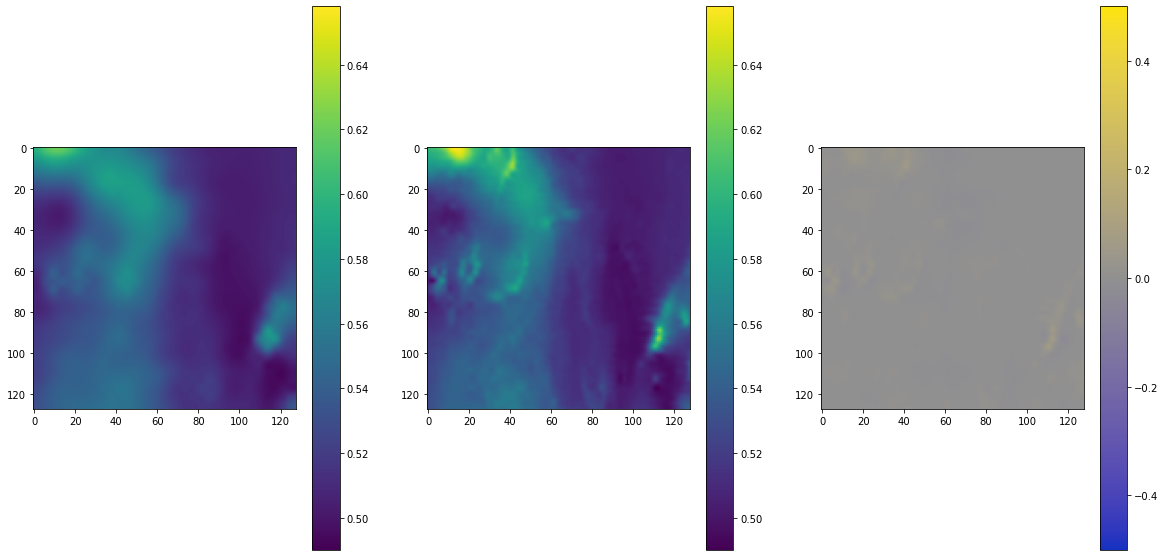

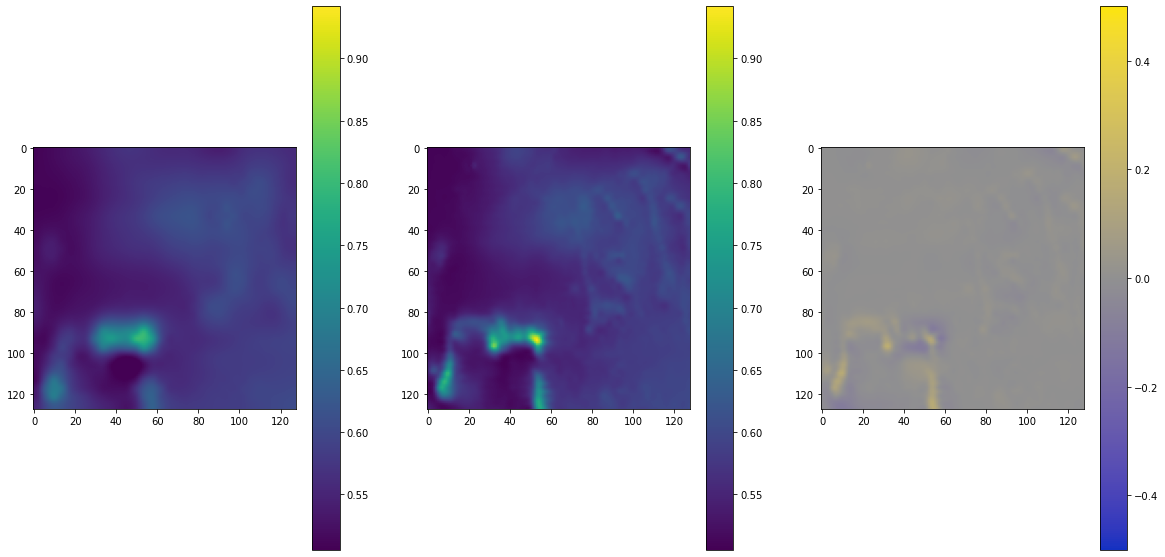

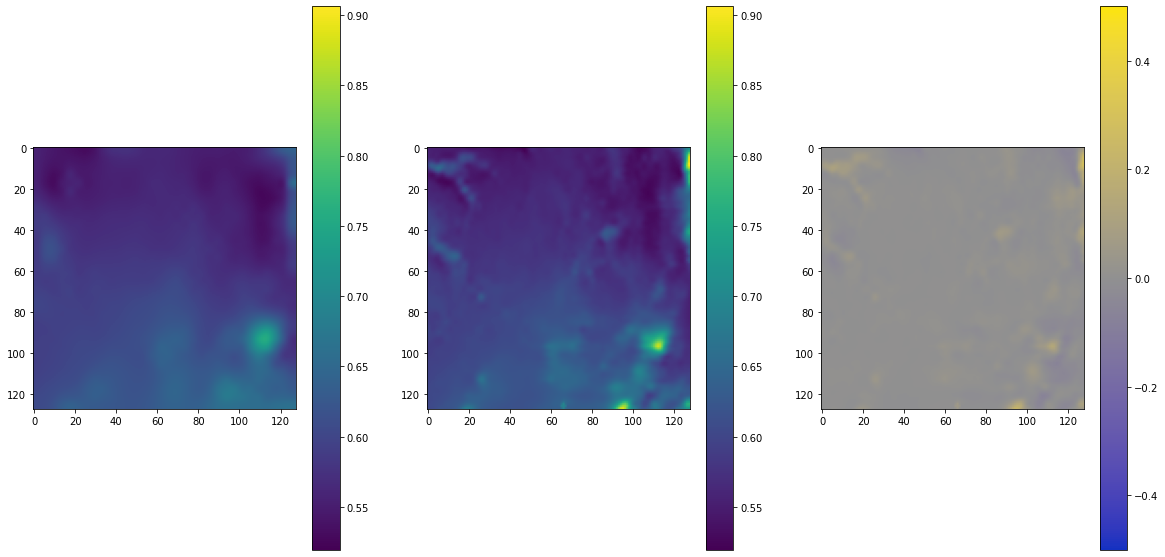

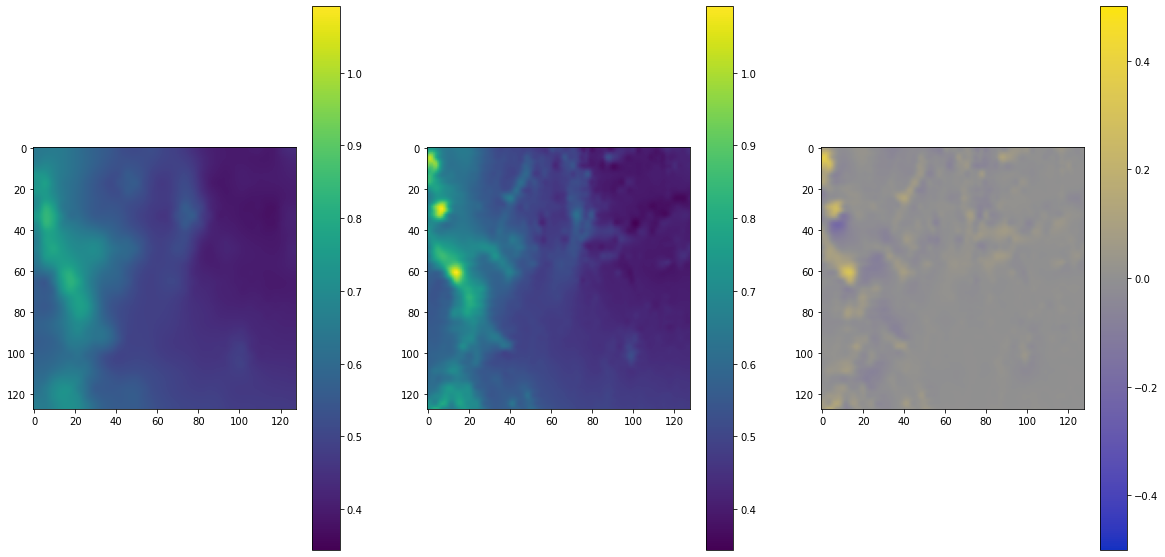

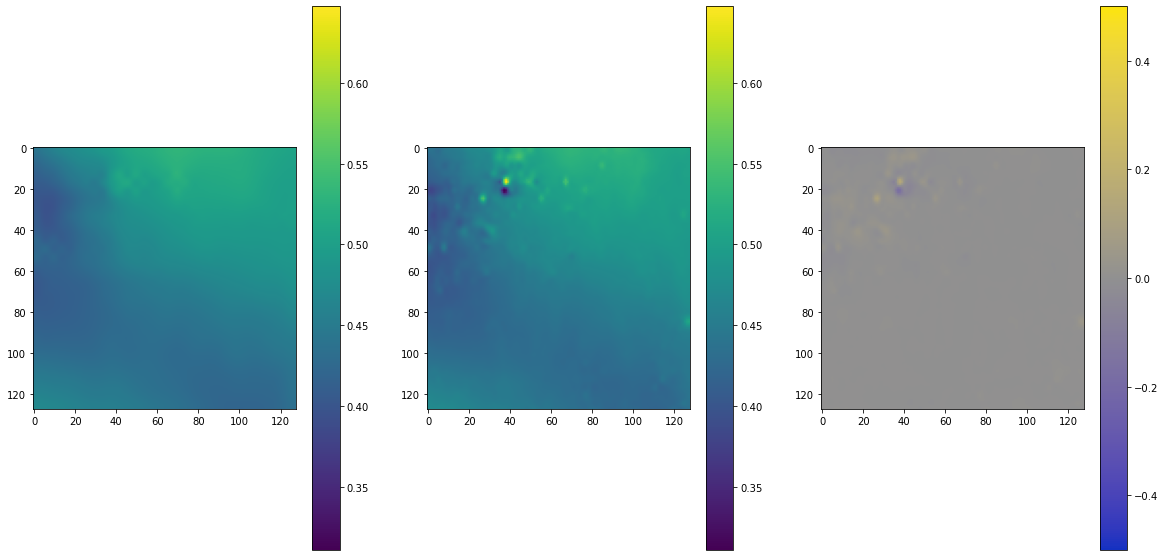

In [5]:
for i in range(len(val_indices)):
    check_tiles(
        lr_path=f"data_train/P738/tif/train/lr/{i}_P738_x4_250_clip_lr_4-0.tif",
        hr_path=f"data_train/P738/tif/train/hr/{i}_P738_x1_62-5_clip_hr_1-0.tif",
        index=i,
        ext="tif",
        s=128
    )
